In [2]:
from fastai.vision import *
import os
#from efficientnet_pytorch import EfficientNet
#import torchvision.models as models
import pandas as pd
import torch
import torch.nn as nn

In [3]:
data_path = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset')
os.environ["CUDA_VISIBLE_DEVICES"]='7'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

In [7]:
data_pave = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(),size=128)    #Data augmentation? -> use tfms with a size of 64
        .databunch(path='.', bs=64, device= torch.device('cuda:7')))       

Exception: It's not possible to apply those transforms to your dataset:
 Expected object of scalar type Float but got scalar type Double for argument #3 'mat2' in call to _th_addmm_out

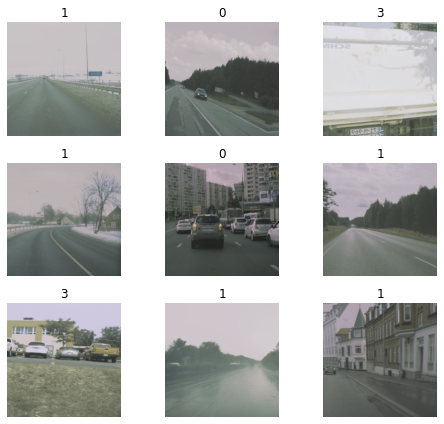

In [5]:
data_pave.show_batch(rows=3, figsize=(7,6))

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [8]:
b6_model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=4)
learn = Learner(data_pave, b6_model, metrics=[accuracy, error_rate], 
                callback_fns=[ShowGraph, BnFreeze, partial(callbacks.SaveModelCallback, monitor='accuracy', name='best_acc')])

Loaded pretrained weights for efficientnet-b6


In [8]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.unfreeze()
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [9]:
optimal_lr = find_appropriate_lr(learn)
print(optimal_lr)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
0.001202264434617413


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.236991,0.182281,0.948571,0.051429,09:25
1,0.272974,0.214619,0.929011,0.070989,09:24
2,0.246343,0.309528,0.904835,0.095165,09:22
3,0.279633,0.234238,0.921978,0.078022,09:14
4,0.226344,0.168759,0.939121,0.060879,09:16
5,0.207109,0.159832,0.943297,0.056703,09:27
6,0.215272,0.170446,0.935385,0.064615,09:22
7,0.171487,0.170739,0.936923,0.063077,09:20
8,0.138816,0.166633,0.938462,0.061538,09:18
9,0.118282,0.110562,0.964615,0.035385,09:17


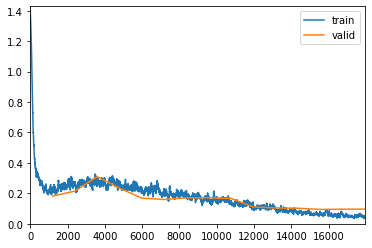

Better model found at epoch 0 with accuracy value: 0.9485714435577393.
Better model found at epoch 9 with accuracy value: 0.9646154046058655.
Better model found at epoch 10 with accuracy value: 0.9657142758369446.
Better model found at epoch 11 with accuracy value: 0.9676923155784607.
Better model found at epoch 12 with accuracy value: 0.9694505333900452.
Better model found at epoch 14 with accuracy value: 0.9696703553199768.


In [9]:
learn.fit_one_cycle(15, 0.0015)
#learn.recorder.plot_loss()
learn.export('/home/jns2szh/code/b6-15-epoch.pkl')
learn.save('/home/jns2szh/code/b6-15-rn50')

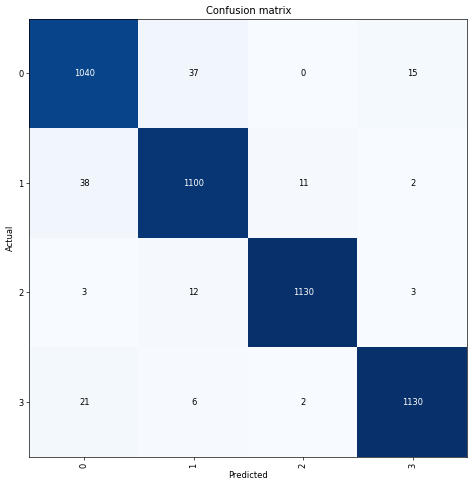

In [16]:
#learn.load('best_kappa')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [15]:
#TTA and submission
# remove zoom from FastAI TTA
tta_params = {'beta':0.12, 'scale':1.0}
PATH = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/')
sample_df = pd.read_csv('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/inference.csv')
learn.data.add_test(ImageList.from_df(
    sample_df, PATH
))

In [28]:
#preds,y = learn.TTA(ds_type=DatasetType.Test, **tta_params)
preds,y = learn.TTA(ds_type=DatasetType.Test)
preds_processed = torch.softmax(preds, dim=1)[:, 1].numpy() #in case of forward is focal loss

In [31]:
#from torch.nn import functional as F
#outputs = F.softmax(preds, dim=1)
result = outputs.cuda().data.cpu().numpy()
print(len(result))
#result = preds.cuda().data.cpu().numpy()
dry = []
wet = []
snowy = []
na = []

for i in range(len(result)):
    dry.append(result[i][0])
    wet.append(result[i][1])
    snowy.append(result[i][2])
    na.append(result[i][3])
cont_list = {'dry':dry, 'wet':wet, 'snowy':snowy, 'na':na}
df = pd.DataFrame(cont_list, columns=['dry','wet','snowy','na'])
df.to_csv('result.csv')

16561


## transfer learning

In [16]:
learn = load_learner('/home/jns2szh/code/','b6-15-epoch.pkl')
preds,y = learn.get_preds(ds_type=DatasetType.Test)

AttributeError: 'NoneType' object has no attribute 'dataset'